# Classifying legal sentences with a simple neural network
-----

## Imports

In [24]:
import re
import nltk
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix


## Read the wild data

The file "dados_pdf_falencias.csv" contains the raw data extract directed from the PDFs. It also contains some data like "document type" or initial and final page" -- extracted from the file name. 

In [2]:
df = pd.read_csv('../../dataset2/dados_pdf_falencias.csv')

## Standarlize the document types

There are different spellings for the same document type, like "Documentos" or "Documento". This code is meant to standarlize some of this variances. 

In [3]:
df = df.replace({'tipo_documento': r'Documento[s]* *([0-9]*|Diversos)*.*'}, {
                'tipo_documento': 'Documento'}, regex=True)
df = df.replace({'tipo_documento': r'.+Ofício.+'},
                {'tipo_documento': 'Ofício'}, regex=True)
df = df.replace({'tipo_documento': r'Ofício Recebido'}, {
                'tipo_documento': 'Ofício'}, regex=True)
df = df.replace({'tipo_documento': r'Ofícios'}, {
                'tipo_documento': 'Ofício'}, regex=True)
df = df.replace(
    {'tipo_documento': r'^([Aa]córdão[s]*.+)'}, {'tipo_documento': 'Acórdão'}, regex=True)
df = df.replace(
    {'tipo_documento': r'^(Certid[ãõ][oe]s*.+)'}, {'tipo_documento': 'Certidão'}, regex=True)
df = df.replace(
    {'tipo_documento': r'^(Petiç[ãõ][oe]s*.+)'}, {'tipo_documento': 'Certidão'}, regex=True)
df = df.replace(
    {'tipo_documento': r'Sentença[s]*'}, {'tipo_documento': 'Sentenças'}, regex=True)
df = df.replace({'tipo_documento': r'Carta Precatória'}, {
                'tipo_documento': 'Cartas Precatórias'}, regex=True)
df = df.replace({'tipo_documento': r'Carta Precatória Distribuída'}, {
                'tipo_documento': 'Cartas Precatórias'}, regex=True)
df = df.replace({'tipo_documento': r'Decisão Interlocutória - 2ª Instância'},
                {'tipo_documento': 'Decisão'}, regex=True)
df = df.replace(
    {'tipo_documento': r'.*Despacho[s]*.*'}, {'tipo_documento': 'Despachos'}, regex=True)
df = df.replace({'tipo_documento': r'acórdão'}, {
                'tipo_documento': 'Acórdão'}, regex=True)
df = df.replace({'tipo_documento': r'DECISÃO MONOCRATICA - TERMINATIVA'}, {
                'tipo_documento': 'Decisão'}, regex=True)

## Extract who has signed the document and when they did so

In [4]:
dates = []
signers = []
for index, row in df.iterrows():
    pdf_string = df.iloc[index]['string']
    pdf_string = pdf_string.lower()

    '''
    Tries to find the signature date
    '''
    data_doc = ''
    index_date = pdf_string.find("protocolado em")
    if index_date != -1:
        data_doc = pdf_string[index_date+15:index_date+25]
    else:
        index_date = pdf_string.find("liberado nos autos em")
        if index_date != -1:
            data_doc = pdf_string[index_date+22:index_date+32]

    '''
    Tries to find who has signed the documento
    '''
    nome_assinador = ''
    index_name = pdf_string.find("assinado digitalmente por")
    if index_name != -1:
        index_end_name = pdf_string[index_name:].find(',')
        if index_end_name != -1:
            nome_assinador = pdf_string[index_name +
                                        26:index_name+index_end_name]
        else:
            nome_assinador = pdf_string[index_name+26:index_name+106]

    dates.append(data_doc)
    signers.append(nome_assinador)

df['data_doc'] = dates
df['nome_assinador'] = signers

## Reduce the DataFrame to the documents written by the judger only

It as a project choice to reduce the dataset to only those documents written by the judger, in order to be possible to classify them as positive or negative.

In [5]:
df_filtered = df[(df['tipo_documento'] == 'Sentenças') | (df['tipo_documento']
                                                == 'Despachos') | (df['tipo_documento'] == 'Decisão') | (df['tipo_documento'] == 'Acórdão')]
df_filtered.reset_index(drop=True, inplace=True)

## Clean each string

This excerpt of code cleans each string removing some repetitive text, heards, footers and special characters.

In [6]:
pdf_strings = []
for index, row in df_filtered.iterrows():
    pdf_string = df_filtered.iloc[index]['string']
    pdf_string = pdf_string.lower()
     
    index_beg_sentence = pdf_string.find('vistos')

    if index_beg_sentence > -1:
        pdf_string = pdf_string[index_beg_sentence+6:]

    pdf_string = re.sub(
        r'.*\n.*\n.*\n.*\n.*\n.*\nhorário de atendimento ao público:.*', '', pdf_string)
    pdf_string = re.sub(
        r'tribunal de justiça do estado de são paulo\ncomarca.*\n.*\n.*\n.*\n.*\n.*', '', pdf_string)

    #Tries to remove signature text from the PDF strings
    pdf_string = re.sub(
        '(para conferir o original)(.+?)(e código [0-9A-za-z]+\.)', '', pdf_string)
    pdf_string = re.sub(
        '(este documento é cópia do original).+?(às [0-9]{2}:[0-9]{2} , sob o número [A-Za-z0-9]+\.)', '', pdf_string)
    pdf_string = re.sub(
        '(este documento é cópia do original).+?(liberado nos autos em [0-9]{2}\/[0-9]{2}\/[0-9]{4} às [0-9]{2}:[0-9]{2} \.)', '', pdf_string)
    pdf_string = re.sub(
        r'[documento ]*assinado digitalmente nos termos da lei 11.419/2006[,\.]*', '', pdf_string)
    pdf_string = re.sub(
        'conforme impressão à margem direita', '', pdf_string)
     
    pdf_string = re.sub(r'\n', ' ', pdf_string)
    pdf_string = re.sub(r'\x0c', ' ', pdf_string)
    pdf_strings.append(pdf_string)

df_filtered['string'] = pdf_strings

<ipython-input-6-899edf1deba7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['string'] = pdf_strings


## Remove stopwords

The stopwords are usually articles, prepositions and conjuctions. Those sort of words are removed by this code.

In [7]:
stopwords = nltk.corpus.stopwords.words('portuguese')
for index, row in df_filtered.iterrows():
    example = row['string']
    text_tokens = word_tokenize(example)
    tokens_without_sw = [
        word for word in text_tokens if not word in stopwords and not word in string.punctuation]
    example = ' '.join([str(elem) for elem in tokens_without_sw])
    df_filtered.at[index, 'string'] = example

## Label a fraction of the dataset by using regular expressions

It was a project choice to use some regular expressions to roughly classify some examples that are clearly positive or negative.

In [8]:
exprs_pos = ['decreto falência', 'decreto quebra']
exprs_neg = ['elidir pedido de falência', 'elidir falência',
                'extingo presente ação', 'extingo processo']

count_exp_pos = []
count_exp_neg = []

for index, row in df_filtered.iterrows():
    example = row['string']

    count_pos = 0
    count_neg = 0
    for expr in exprs_pos:
        count_pos += example.count(expr)

    for expr in exprs_neg:
        count_neg += example.count(expr)

    count_exp_neg.append(count_neg)
    count_exp_pos.append(count_pos)
    
df2 = pd.DataFrame({'positive': count_exp_pos,
                    'negative': count_exp_neg})

df2.clip(upper=1, inplace=True)
df_filtered = pd.concat([df_filtered, df2], axis=1)

## Embbed dataset

Each document string is translated to a vector of size 1000 that represents the contexts present in that text. This is done using Doc2Vec algorithm. 

In [9]:
vec_size=1000

In [10]:
tagged_data = [TaggedDocument(words=word_tokenize(str(doc).lower()), tags=[
                                str(i)]) for i, doc in enumerate(df_filtered['string'])]
model = Doc2Vec(size=vec_size, alpha=0.025, min_alpha=0.00025, min_count=1, dm=1)
model.build_vocab(tagged_data)
max_epochs = 5
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data, total_examples=model.corpus_count,
                epochs=model.iter)
    model.alpha -= 0.0002
    model.min_alpha = model.alpha
model.save("d2v_10k.model")

/home/pedro/.local/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


<ipython-input-10-a260b78d483d>:9: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  epochs=model.iter)


iteration 1
iteration 2
iteration 3
iteration 4


In [11]:
vecs = []
for dv in model.docvecs.vectors_docs:
    vecs.append(dv)
df_vectorized = pd.DataFrame(vecs, columns=list(range(vec_size)))
df_vectorized = pd.concat([df_vectorized, df_filtered['positive'], df_filtered['negative']], axis=1)

## Split the training and validation sets

The examples that could be labeled via regular expressions were reserved to training. The other examples that were manually labeled were used as validation set.

In [12]:
df_train = df_vectorized[(df_vectorized['positive'] > 0) ^ (df_vectorized['negative'] > 0)]

X_train = df_train[df_train.columns[:vec_size]].to_numpy()
Y_train = df_train[df_train.columns[vec_size:vec_size+1]].to_numpy()

In [29]:
np.unique(Y_train, return_counts=True)

(array([0, 1]), array([115, 896]))

In [13]:
gt = pd.read_csv('gt.csv')
manually_labeled = [17839, 18702, 18979, 19264, 28857, 21568, 28498, 28739, 28740, 7202, 7267, 14465, 16146, 19453, 20414, 28756, 28769, 28793, 28809, 25308, 25367, 26480, 26489, 28443, 28481, 28490, 28515, 28559, 28566, 28598, 28710, 28745, 28749, 7199, 7315]

X_val = df_vectorized.iloc[manually_labeled][df_train.columns[:vec_size]]
Y_val = gt['positive'][manually_labeled]

In [30]:
np.unique(Y_val, return_counts=True)

(array([0, 1]), array([24, 11]))

## Create a classifier and train

This is a simple neural network with 4 hidden layers of sizes 50, 100, 50 and 1. The activation function is ReLU and the loss is Cross-Entropy. 

In [14]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(50, 100, 50, 1), random_state=1)
clf.fit(X_train, Y_train)

/home/pedro/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(50, 100, 50, 1), random_state=1,
              solver='lbfgs')

## Evaluate

The model was evaluated by predicting over a set that were manually labeled. 

In [42]:
Y_pred = clf.predict(X_val)

In [43]:
print('Accuracy: {0}'.format(clf.score(X_val, Y_val)))
print('Precision: {0}'.format(precision_score(Y_val, Y_pred)))
print('Recall: {0}'.format(recall_score(Y_val, Y_pred)))

Accuracy: 0.5714285714285714
Precision: 0.4090909090909091
Recall: 0.8181818181818182


In [44]:
cm = confusion_matrix(Y_val, Y_pred)

Text(0.5, 1.0, 'Confusion matrix')

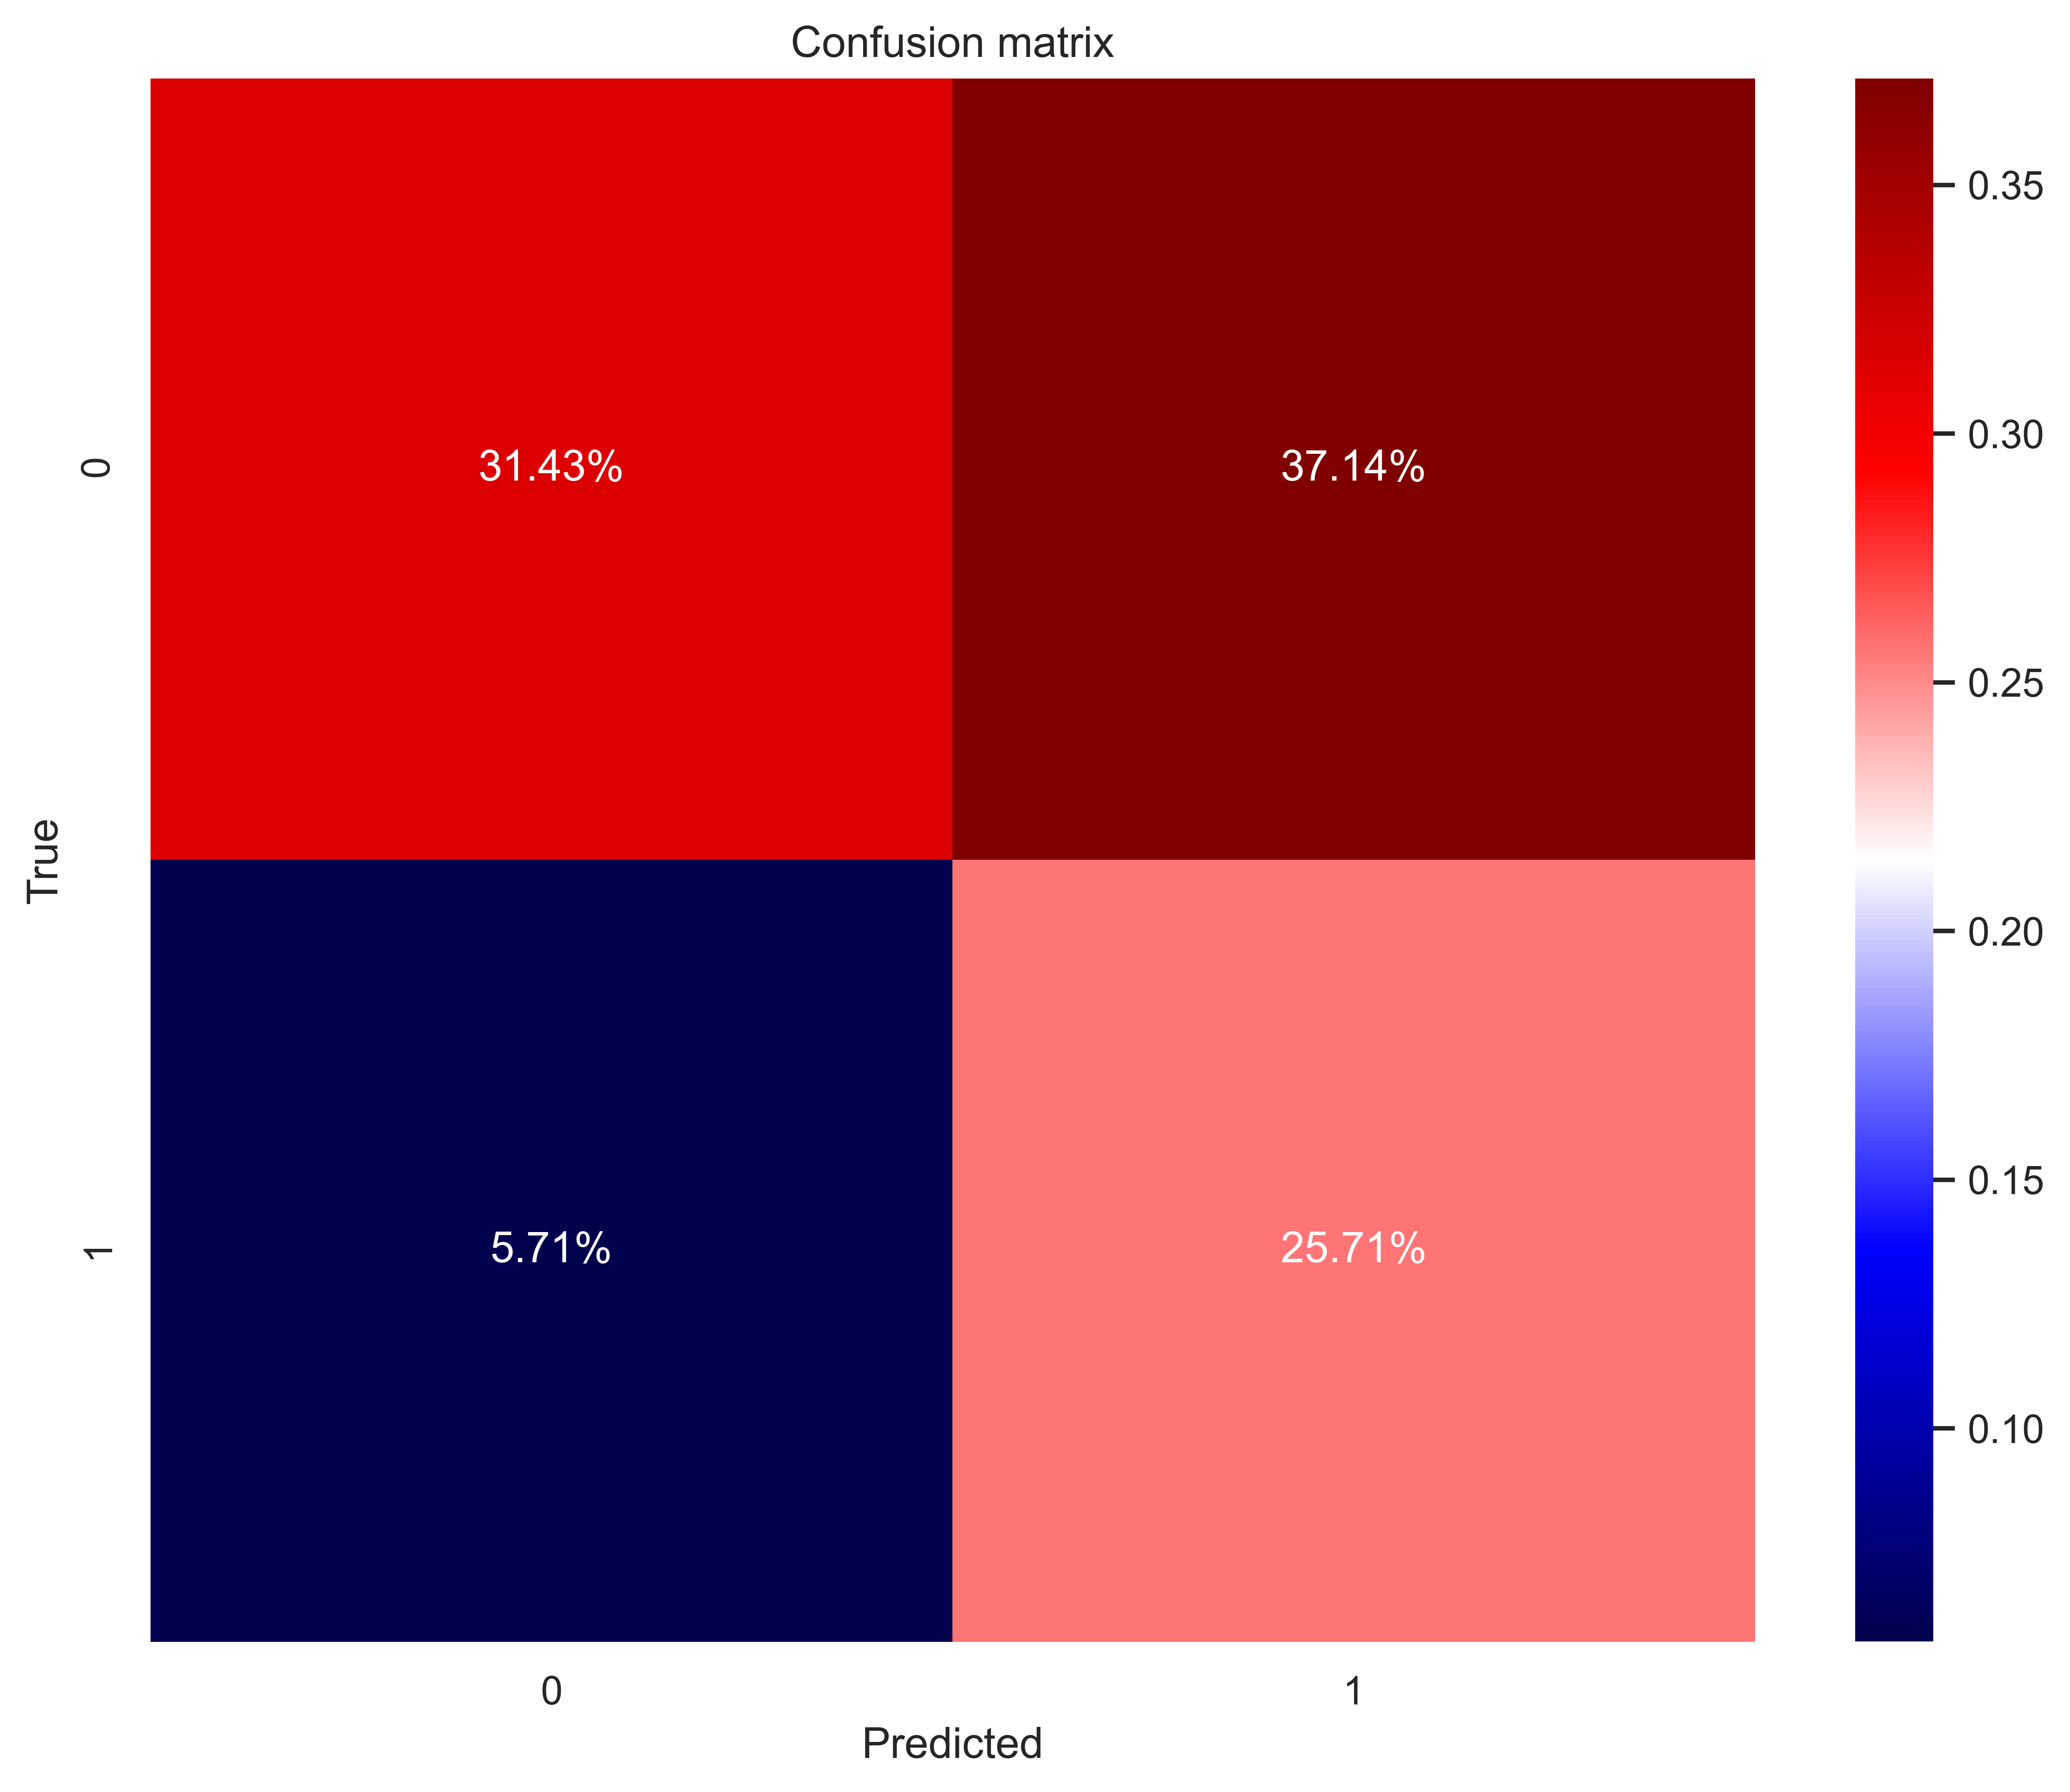

In [46]:
plt.figure(figsize=(10,8))
sns.set(font_scale=1)  # crazy big
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='seismic')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')

### Correctly classified positive example

In [69]:
df_filtered['string'][manually_labeled[8]]

'cite-se réu apresentar contestação prazo 10 dias conste citação réu prazo contestar poderá depositar valor correspondente total crédito acrescido correção monetária juros honorários advocatícios ora fixados 10 sobre valor dado causa hipótese falência decretada art 98 lei 11.101/2005 conste mandado réu prazo contestar poderá pleitear recuperação judicial art 95 lei 11.101/2005 cumpra-se int guarulhos 17 março 2014. processo nº 1002471-91.2014.8.26.0224 p. 1'

In [70]:
Y_val[manually_labeled[8]]

1